In [1]:
!gdown 1VAe4eOEnKOtW1G_7zBdp9kvDHcYPtBMZ
!unzip -q data.zip -d data/


Downloading...
From (original): https://drive.google.com/uc?id=1VAe4eOEnKOtW1G_7zBdp9kvDHcYPtBMZ
From (redirected): https://drive.google.com/uc?id=1VAe4eOEnKOtW1G_7zBdp9kvDHcYPtBMZ&confirm=t&uuid=9f7a0c99-da3d-4457-b64f-8b16d32dfc88
To: /content/data.zip
100% 1.46G/1.46G [00:08<00:00, 178MB/s] 


# 1. Install and Import

In [16]:
!pip -q install pillow tqdm

In [17]:
import os, json, math, unicodedata, random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt


# 2. Config

In [18]:
@dataclass
class CFG:
    # paths
    DATA_ROOT = "/content/data"
    SPLIT_JSON = "/content/data/split.json"

    # training
    seed = 3407
    epochs = 60
    batch_size = 32
    lr = 1e-3
    weight_decay = 1e-4
    num_workers = 2

    # image preprocessing
    img_h = 64              # chiều cao cố định
    max_w = 512             # giới hạn width sau resize (cắt/pad), có thể tăng nếu chữ dài
    pad_value = 1.0         # nền trắng (sau normalize)

    # model
    cnn_channels = 256
    rnn_hidden = 256
    rnn_layers = 2
    dropout = 0.1

    # Early stopping config
    patience = 7          # số epoch chờ không cải thiện
    min_delta = 1e-4      # cải thiện tối thiểu để được tính là tốt hơn
    wait = 0              # bộ đếm
    best_metric = -1.0    # vì bạn đang dùng va_acc (càng lớn càng tốt)
    best_epoch = 0

    # Vocal train/val/test or full vocal
    use_vocab_full = 1
    use_vocab_train_val_test = 0

    # misc
    device = "cuda" if torch.cuda.is_available() else "cpu"
    amp = True

cfg = CFG()


# 3. Utils: seed, normalize text (quan trọng với tiếng Việt có dấu)

In [19]:
def set_seed(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)

def norm_text(s: str) -> str:
    # Chuẩn hoá Unicode về NFC để tránh trường hợp dấu dạng tổ hợp
    s = s.strip()
    s = unicodedata.normalize("NFC", s)
    return s


# 4. Build vocab từ train (CTC cần bảng ký tự)

## Build Vocab Impart train/test/val

In [20]:
def build_vocab(samples: List[Dict]) -> Tuple[Dict[str,int], Dict[int,str]]:
    chars = set()
    for x in samples:
        t = norm_text(x["text"])
        for ch in t:
            chars.add(ch)
    chars = sorted(list(chars))
    stoi = {"<blank>": 0}
    for i, ch in enumerate(chars, start=1):
        stoi[ch] = i
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos

def encode_text(text: str, stoi: Dict[str,int]) -> List[int]:
    text = norm_text(text)
    return [stoi[ch] for ch in text]

def decode_ctc(tokens: List[int], itos: Dict[int,str], blank_id=0) -> str:
    # collapse repeats, remove blank
    out = []
    prev = None
    for t in tokens:
        if t == blank_id:
            prev = t
            continue
        if prev == t:
            continue
        out.append(itos[t])
        prev = t
    return "".join(out)


## Built vocal handmade

In [21]:
VIET_CHARS = list(
    "aáàảãạăắằẳẵặâấầẩẫậ"
    "b"
    "c"
    "dđ"
    "eéèẻẽẹêếềểễệ"
    "g"
    "h"
    "iíìỉĩị"
    "k"
    "l"
    "m"
    "n"
    "oóòỏõọôốồổỗộơớờởỡợ"
    "p"
    "q"
    "r"
    "s"
    "t"
    "uúùủũụưứừửữự"
    "v"
    "x"
    "yýỳỷỹỵ"
)

# thêm chữ HOA
VIET_CHARS += [c.upper() for c in VIET_CHARS]

# thêm chữ số + space nếu cần
EXTRA_CHARS = list("0123456789 ")
def build_vocab_full(samples):
    chars = set()

    # (A) thêm bảng chữ cái chuẩn
    for ch in VIET_CHARS + EXTRA_CHARS:
        chars.add(ch)

    # (B) thêm ký tự thực tế trong data
    for x in samples:
        t = norm_text(x["text"])
        for ch in t:
            chars.add(ch)

    chars = sorted(chars)

    stoi = {"<blank>": 0}
    for i, ch in enumerate(chars, start=1):
        stoi[ch] = i
    itos = {i: ch for ch, i in stoi.items()}

    return stoi, itos


## Check Vocab

In [22]:
import csv

# Load JSON
with open(cfg.SPLIT_JSON, "r", encoding="utf-8") as f:
    split = json.load(f)

train_items = split["train"]
val_items   = split["val"]
test_items  = split["test"]

stoi1, itos1 = build_vocab(train_items + val_items + test_items)
stoi2, itos2 = build_vocab(train_items + val_items)
stoi3, itos3 = build_vocab(train_items)
stoi4, itos4 = build_vocab_full((train_items + val_items + test_items))


print(f"Size vocal off train/val/test {len(stoi1)}")
print(f"Size vocal off train/val {len(stoi2)}")
print(f"Size vocal off train {len(stoi3)}")
print(f"Size vocal full {len(stoi4)}")

Size vocal off train/val/test 148
Size vocal off train/val 146
Size vocal off train 146
Size vocal full 197


# 5) Dataset + Collate (pad theo batch)

In [23]:
class OCRDataset(Dataset):
    def __init__(self, items: List[Dict], data_root: str, stoi: Dict[str,int]):
        self.items = items
        self.data_root = data_root
        self.stoi = stoi

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x = self.items[idx]
        rel = x["image_path"].replace("\\", "/")
        img_path = os.path.join(self.data_root, rel)

        text = norm_text(x["text"])
        # load image
        img = Image.open(img_path).convert("L")  # grayscale
        # resize keep aspect by height
        w, h = img.size
        new_h = cfg.img_h
        new_w = int(w * (new_h / h))
        new_w = min(new_w, cfg.max_w)
        img = img.resize((new_w, new_h), Image.BILINEAR)

        # to tensor float in [0,1]
        arr = np.array(img).astype(np.float32) / 255.0
        # normalize: nền trắng ~1, chữ đen ~0. Để model dễ, ta đảo: chữ=1, nền=0
        arr = 1.0 - arr
        # (H,W) -> (1,H,W)
        arr = torch.from_numpy(arr).unsqueeze(0)

        target = torch.tensor(encode_text(text, self.stoi), dtype=torch.long)
        return arr, target, text, x["image_path"]

def collate_fn(batch):
    imgs, targets, texts, paths = zip(*batch)
    # pad images by width
    H = imgs[0].shape[-2]
    widths = [im.shape[-1] for im in imgs]
    maxW = min(max(widths), cfg.max_w)

    padded = torch.full((len(imgs), 1, H, maxW), fill_value=0.0, dtype=torch.float32)
    for i, im in enumerate(imgs):
        w = im.shape[-1]
        w = min(w, maxW)
        padded[i, :, :, :w] = im[:, :, :w]

    # concatenate targets for CTC
    tgt_lens = torch.tensor([t.numel() for t in targets], dtype=torch.long)
    tgt_concat = torch.cat(targets, dim=0)

    return padded, tgt_concat, tgt_lens, list(texts), list(paths), torch.tensor(widths, dtype=torch.long)


# 6) Model: CNN -> sequence -> BiLSTM -> CTC logits

## Mô hình 1: CNN -> sequence -> BiLSTM -> CTC logits

In [24]:
class CRNN_CTC(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # CNN downsample mainly on height, keep width as "time"
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d((2,2)),  # H/2, W/2

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d((2,2)),  # H/4, W/4

            nn.Conv2d(128, cfg.cnn_channels, 3, 1, 1),
            nn.BatchNorm2d(cfg.cnn_channels),
            nn.SiLU(True),
            nn.MaxPool2d((2,1)),  # H/8, W/4  (giữ width nhiều hơn)
        )
        self.dropout = nn.Dropout(cfg.dropout)

        # RNN over time steps (width dimension)
        self.rnn = nn.LSTM(
            input_size=cfg.cnn_channels,
            hidden_size=cfg.rnn_hidden,
            num_layers=cfg.rnn_layers,
            dropout=cfg.dropout if cfg.rnn_layers > 1 else 0.0,
            bidirectional=True,
            batch_first=False
        )
        self.fc = nn.Linear(cfg.rnn_hidden * 2, num_classes)

    def forward(self, x):
        # x: (B,1,H,W)
        feat = self.cnn(x)            # (B,C,H',W')
        feat = self.dropout(feat)

        # pool over height to get (B,C,W')
        feat = feat.mean(dim=2)          # average over height -> (B,C,W')
        # -> (W',B,C)
        feat = feat.permute(2,0,1)

        y, _ = self.rnn(feat)         # (T,B,2H)
        logits = self.fc(y)        # (T,B,classes)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs


## Mô hình 2: ResNet-lite + SE + SiLU + BiLSTM + CTC

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        hidden = max(8, ch // r)
        self.fc1 = nn.Conv2d(ch, hidden, 1)
        self.fc2 = nn.Conv2d(hidden, ch, 1)

    def forward(self, x):
        s = x.mean(dim=(2,3), keepdim=True)
        s = F.silu(self.fc1(s))
        s = torch.sigmoid(self.fc2(s))
        return x * s

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=(1,1), use_se=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.se    = SEBlock(out_ch) if use_se else nn.Identity()

        self.proj = None
        if in_ch != out_ch or stride != (1,1):
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = x
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        if self.proj is not None:
            identity = self.proj(identity)
        out = F.silu(out + identity)
        return out

class CRNN_CTC_Strong(nn.Module):
    """
    Input: (B,1,H,W)
    Output: log_probs (T,B,C)
    """
    def __init__(self, num_classes: int, cnn_out=256, rnn_hidden=256, rnn_layers=2, dropout=0.1):
        super().__init__()

        # Stem: downsample BOTH a bit (H/2, W/2) nhưng không quá mạnh
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=(2,2), padding=1, bias=False),  # H/2, W/2
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )

        # Stage1: giữ W, giảm H tiếp
        self.stage1 = nn.Sequential(
            ResBlock(64, 128, stride=(2,1), use_se=True),  # H/4, W/2
            ResBlock(128, 128, stride=(1,1), use_se=True),
        )

        # Stage2: giảm H tiếp, W giảm nhẹ
        self.stage2 = nn.Sequential(
            ResBlock(128, 192, stride=(2,1), use_se=True), # H/8, W/2
            ResBlock(192, 192, stride=(1,1), use_se=True),
        )

        # Stage3: đưa về cnn_out, W vẫn giữ tốt
        self.stage3 = nn.Sequential(
            ResBlock(192, cnn_out, stride=(2,1), use_se=True),  # H/16, W/2
            ResBlock(cnn_out, cnn_out, stride=(1,1), use_se=True),
        )

        self.dropout = nn.Dropout(dropout)

        self.rnn = nn.LSTM(
            input_size=cnn_out,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            dropout=dropout if rnn_layers > 1 else 0.0,
            bidirectional=True,
            batch_first=False
        )
        self.fc = nn.Linear(rnn_hidden * 2, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.dropout(x)

        # pool over height -> sequence over width
        x = x.mean(dim=2)        # (B,C,W')
        x = x.permute(2,0,1)     # (T,B,C)

        y, _ = self.rnn(x)       # (T,B,2H)
        logits = self.fc(y)      # (T,B,classes)
        return F.log_softmax(logits, dim=-1)


# 7) Metrics: WordAcc, CER, WER (train/val/test)

In [26]:
def edit_distance(a, b):
    # classic DP
    n, m = len(a), len(b)
    dp = list(range(m+1))
    for i in range(1, n+1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, m+1):
            cur = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = cur
    return dp[m]

@torch.no_grad()
def compute_metrics(preds: List[str], gts: List[str]):
    # Word accuracy: exact match (word-level)
    correct = sum([p == t for p, t in zip(preds, gts)])
    word_acc = correct / max(1, len(gts))

    # CER: edit distance over characters / total chars
    cer_num, cer_den = 0, 0
    for p, t in zip(preds, gts):
        cer_num += edit_distance(list(p), list(t))
        cer_den += max(1, len(t))
    cer = cer_num / max(1, cer_den)

    # WER: edit distance over word tokens / total words
    wer_num, wer_den = 0, 0
    for p, t in zip(preds, gts):
        pw = p.split()
        tw = t.split()
        wer_num += edit_distance(pw, tw)
        wer_den += max(1, len(tw))
    wer = wer_num / max(1, wer_den)

    return word_acc, wer, cer


# 8) Train/Eval loop (log theo epoch + save checkpoint)

In [27]:
def greedy_decode(log_probs, itos, blank_id=0):
    # log_probs: (T,B,C)
    pred_tokens = log_probs.argmax(dim=-1)  # (T,B)
    pred_texts = []
    for b in range(pred_tokens.shape[1]):
        toks = pred_tokens[:, b].tolist()
        pred_texts.append(decode_ctc(toks, itos, blank_id=blank_id))
    return pred_texts

def count_params(model):
    return sum(p.numel() for p in model.parameters())

def run_epoch(model, loader, criterion, optimizer=None, scaler=None, train=False, itos=None):
    model.train() if train else model.eval()
    total_loss = 0.0
    all_preds, all_gts = [], []

    pbar = tqdm(loader, leave=False)
    for imgs, tgt_concat, tgt_lens, gt_texts, paths, raw_widths in pbar:
        imgs = imgs.to(cfg.device)
        tgt_concat = tgt_concat.to(cfg.device)
        tgt_lens = tgt_lens.to(cfg.device)

        # AMP (API mới)
        with torch.amp.autocast(device_type="cuda", enabled=(cfg.amp and cfg.device=="cuda")):
            log_probs = model(imgs)  # (T,B,C)
            T, B, C = log_probs.shape
            in_lens = torch.full((B,), fill_value=T, dtype=torch.long, device=cfg.device)
            loss = criterion(log_probs, tgt_concat, in_lens, tgt_lens)

        if train:
            optimizer.zero_grad(set_to_none=True)
            if scaler is not None:
                scaler.scale(loss).backward()
                # (khuyên) grad clip để ổn định
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()

        total_loss += loss.item() * B

        if itos is not None:
            preds = greedy_decode(log_probs.detach(), itos)
            all_preds.extend([norm_text(p) for p in preds])
            all_gts.extend([norm_text(t) for t in gt_texts])

        pbar.set_postfix(loss=float(loss.item()))

    avg_loss = total_loss / max(1, len(loader.dataset))
    word_acc, wer, cer = compute_metrics(all_preds, all_gts) if itos is not None else (0,0,0)
    return avg_loss, word_acc, wer, cer


# 9) Main: Load split.json → dataloader → train → save logs/plots → test

In [28]:
# Model2
# model = CRNN_CTC_Strong(
#     num_classes=len(stoi),
#     cnn_out=256,
#     rnn_hidden=256,
#     rnn_layers=2,
#     dropout=cfg.dropout
# ).to(cfg.device)
# print("Total params:", sum(p.numel() for p in model.parameters()))


In [29]:
# Load JSON
with open(cfg.SPLIT_JSON, "r", encoding="utf-8") as f:
    split = json.load(f)

train_items = split["train"]
val_items   = split["val"]
test_items  = split["test"]

# vocab from (train+val+test) và vocab_full
stoi1, itos1 = build_vocab(train_items + val_items + test_items)
print("Vocab size of train/val/test (including blank):", len(stoi1))
print("Example vocab chars:", list(stoi1.keys())[:30])

stoi2, itos2 = build_vocab_full(train_items + val_items + test_items)
print("Vocab size of vocab_full (including blank):", len(stoi2))
print("Example vocab_full chars:", list(stoi2.keys())[:30])

# choose
if cfg.use_vocab_full:
    stoi, itos = stoi2, itos2
    print(f"Using vocab_full with size {len(stoi)}")
elif cfg.use_vocab_train_val_test:
    stoi, itos = stoi1, itos1
    print(f"Using vocab_train_val_test with size {len(stoi)}")
else:
    raise ValueError("Set cfg.use_vocab_full or cfg.use_vocab_train_val_test to True")

Vocab size of train/val/test (including blank): 148
Example vocab chars: ['<blank>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']
Vocab size of vocab_full (including blank): 197
Example vocab_full chars: ['<blank>', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']
Using vocab_full with size 197


In [31]:
import csv, os

train_ds = OCRDataset(train_items, cfg.DATA_ROOT, stoi)
val_ds   = OCRDataset(val_items, cfg.DATA_ROOT, stoi)
test_ds  = OCRDataset(test_items, cfg.DATA_ROOT, stoi)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, collate_fn=collate_fn, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, collate_fn=collate_fn, pin_memory=True)

model1 = CRNN_CTC(num_classes=len(stoi)).to(cfg.device)
print("Total params:", count_params(model1))

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.AdamW(model1.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.amp and cfg.device=="cuda"))

# ReduceLROnPlateau: mode='max' vì theo val_acc
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

log_path = "logs/train_log.csv"
with open(log_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch",
                     "lr",
                     "train_loss","train_word_acc","train_wer","train_cer",
                     "val_loss","val_word_acc","val_wer","val_cer"])

best_val = -1.0
history = {
    "lr": [],
    "train_loss":[], "val_loss":[],
    "train_word_acc":[], "val_word_acc":[],
    "train_wer":[], "val_wer":[],
    "train_cer":[], "val_cer":[]
}

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc, tr_wer, tr_cer = run_epoch(
        model1, train_loader, criterion,
        optimizer=optimizer, scaler=scaler,
        train=True, itos=itos
    )

    va_loss, va_acc, va_wer, va_cer = run_epoch(
        model1, val_loader, criterion,
        optimizer=None, scaler=None,
        train=False, itos=itos
    )

    cur_lr = optimizer.param_groups[0]["lr"]

    # log csv
    with open(log_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, cur_lr, tr_loss, tr_acc, tr_wer, tr_cer, va_loss, va_acc, va_wer, va_cer])

    # history for plotting
    history["lr"].append(cur_lr)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_word_acc"].append(tr_acc); history["val_word_acc"].append(va_acc)
    history["train_wer"].append(tr_wer); history["val_wer"].append(va_wer)
    history["train_cer"].append(tr_cer); history["val_cer"].append(va_cer)

    print(
        f"[Epoch {epoch}/{cfg.epochs}] "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} wer {tr_wer:.4f} cer {tr_cer:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f} wer {va_wer:.4f} cer {va_cer:.4f} | "
        f"lr {cur_lr:.2e}"
    )

    # scheduler step uses val_acc
    scheduler.step(va_acc)

    # save last
    torch.save({
        "epoch": epoch,
        "model_state": model1.state_dict(),
        "stoi": stoi,
        "itos": itos,
        "cfg": cfg.__dict__
    }, "checkpoints/last.ckpt")

    # early stop (maximize val_acc)
    improved = (va_acc > cfg.best_metric + cfg.min_delta)

    if improved:
        cfg.best_metric = va_acc
        cfg.best_epoch = epoch
        cfg.wait = 0

        best_val = va_acc
        torch.save({
            "epoch": epoch,
            "model_state": model1.state_dict(),
            "stoi": stoi,
            "itos": itos,
            "cfg": cfg.__dict__
        }, "checkpoints/best.ckpt")
        torch.save(model1.state_dict(), "checkpoints/best_weights.pth")
        print(f"New best: val_acc={va_acc:.4f} at epoch={epoch}")
    else:
        cfg.wait += 1
        print(f"EarlyStop: no improvement for {cfg.wait}/{cfg.patience}. "
              f"best_acc={cfg.best_metric:.4f} (epoch {cfg.best_epoch})")

    if cfg.wait >= cfg.patience:
        print(f"Early stopping at epoch {epoch}. Best val_acc={cfg.best_metric:.4f} (epoch {cfg.best_epoch}).")
        break

print("Best val word accuracy:", best_val)


/tmp/ipython-input-1971690528.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.amp and cfg.device=="cuda"))


Total params: 3101253


[Epoch 1/60] train loss 5.0561 acc 0.0001 wer 0.9999 cer 0.9172 | val loss 3.7120 acc 0.0012 wer 0.9988 cer 0.8267 | lr 1.00e-03
New best: val_acc=0.0012 at epoch=1


[Epoch 2/60] train loss 2.8504 acc 0.0074 wer 0.9926 cer 0.6760 | val loss 2.5989 acc 0.0139 wer 0.9861 cer 0.6225 | lr 1.00e-03
New best: val_acc=0.0139 at epoch=2


[Epoch 3/60] train loss 2.2082 acc 0.0346 wer 0.9654 cer 0.5486 | val loss 2.3314 acc 0.0375 wer 0.9625 cer 0.5476 | lr 1.00e-03
New best: val_acc=0.0375 at epoch=3


[Epoch 4/60] train loss 1.7259 acc 0.1000 wer 0.9000 cer 0.4421 | val loss 1.7142 acc 0.1254 wer 0.8746 cer 0.4276 | lr 1.00e-03
New best: val_acc=0.1254 at epoch=4


[Epoch 5/60] train loss 1.3399 acc 0.2018 wer 0.7982 cer 0.3571 | val loss 1.4461 acc 0.1995 wer 0.8005 cer 0.3722 | lr 1.00e-03
New best: val_acc=0.1995 at epoch=5


[Epoch 6/60] train loss 1.0644 acc 0.3103 wer 0.6897 cer 0.2891 | val loss 1.4301 acc 0.2113 wer 0.7887 cer 0.3664 | lr 1.00e-03
New best: val_acc=0.2113 at epoch=6


[Epoch 7/60] train loss 0.8463 acc 0.4268 wer 0.5732 cer 0.2327 | val loss 3.8041 acc 0.0313 wer 0.9687 cer 0.7607 | lr 1.00e-03
EarlyStop: no improvement for 1/7. best_acc=0.2113 (epoch 6)


[Epoch 8/60] train loss 0.6875 acc 0.5067 wer 0.4933 cer 0.1942 | val loss 2.5608 acc 0.1015 wer 0.8985 cer 0.5131 | lr 1.00e-03
EarlyStop: no improvement for 2/7. best_acc=0.2113 (epoch 6)


[Epoch 9/60] train loss 0.5360 acc 0.6030 wer 0.3970 cer 0.1518 | val loss 0.9475 acc 0.4281 wer 0.5719 cer 0.2484 | lr 1.00e-03
New best: val_acc=0.4281 at epoch=9


[Epoch 10/60] train loss 0.4372 acc 0.6644 wer 0.3356 cer 0.1262 | val loss 0.8804 acc 0.4889 wer 0.5111 cer 0.2186 | lr 1.00e-03
New best: val_acc=0.4889 at epoch=10


[Epoch 11/60] train loss 0.3489 acc 0.7276 wer 0.2724 cer 0.0990 | val loss 0.8506 acc 0.4957 wer 0.5043 cer 0.2122 | lr 1.00e-03
New best: val_acc=0.4957 at epoch=11


[Epoch 12/60] train loss 0.2868 acc 0.7721 wer 0.2279 cer 0.0819 | val loss 1.2067 acc 0.3747 wer 0.6253 cer 0.2893 | lr 1.00e-03
EarlyStop: no improvement for 1/7. best_acc=0.4957 (epoch 11)


[Epoch 13/60] train loss 0.2256 acc 0.8141 wer 0.1859 cer 0.0652 | val loss 0.7688 acc 0.5571 wer 0.4429 cer 0.1850 | lr 1.00e-03
New best: val_acc=0.5571 at epoch=13


[Epoch 14/60] train loss 0.1920 acc 0.8404 wer 0.1596 cer 0.0554 | val loss 6.5529 acc 0.0077 wer 0.9923 cer 0.9131 | lr 1.00e-03
EarlyStop: no improvement for 1/7. best_acc=0.5571 (epoch 13)


[Epoch 15/60] train loss 0.1641 acc 0.8640 wer 0.1360 cer 0.0474 | val loss 1.0691 acc 0.4193 wer 0.5807 cer 0.2471 | lr 1.00e-03
EarlyStop: no improvement for 2/7. best_acc=0.5571 (epoch 13)


[Epoch 16/60] train loss 0.1414 acc 0.8828 wer 0.1172 cer 0.0400 | val loss 2.2098 acc 0.1841 wer 0.8159 cer 0.4282 | lr 1.00e-03
EarlyStop: no improvement for 3/7. best_acc=0.5571 (epoch 13)


[Epoch 17/60] train loss 0.0744 acc 0.9447 wer 0.0553 cer 0.0185 | val loss 0.7317 acc 0.5993 wer 0.4007 cer 0.1640 | lr 5.00e-04
New best: val_acc=0.5993 at epoch=17


[Epoch 18/60] train loss 0.0429 acc 0.9758 wer 0.0242 cer 0.0081 | val loss 0.7120 acc 0.6199 wer 0.3801 cer 0.1536 | lr 5.00e-04
New best: val_acc=0.6199 at epoch=18


[Epoch 19/60] train loss 0.0348 acc 0.9831 wer 0.0169 cer 0.0057 | val loss 0.7974 acc 0.5834 wer 0.4166 cer 0.1711 | lr 5.00e-04
EarlyStop: no improvement for 1/7. best_acc=0.6199 (epoch 18)


[Epoch 20/60] train loss 0.0314 acc 0.9833 wer 0.0167 cer 0.0057 | val loss 0.8120 acc 0.5943 wer 0.4057 cer 0.1660 | lr 5.00e-04
EarlyStop: no improvement for 2/7. best_acc=0.6199 (epoch 18)


[Epoch 21/60] train loss 0.0264 acc 0.9882 wer 0.0118 cer 0.0040 | val loss 0.7198 acc 0.6406 wer 0.3594 cer 0.1462 | lr 5.00e-04
New best: val_acc=0.6406 at epoch=21


[Epoch 22/60] train loss 0.0251 acc 0.9865 wer 0.0135 cer 0.0043 | val loss 0.7898 acc 0.6067 wer 0.3933 cer 0.1615 | lr 5.00e-04
EarlyStop: no improvement for 1/7. best_acc=0.6406 (epoch 21)


[Epoch 23/60] train loss 0.0332 acc 0.9787 wer 0.0213 cer 0.0066 | val loss 1.1503 acc 0.4526 wer 0.5474 cer 0.2318 | lr 5.00e-04
EarlyStop: no improvement for 2/7. best_acc=0.6406 (epoch 21)


[Epoch 24/60] train loss 0.0420 acc 0.9707 wer 0.0293 cer 0.0093 | val loss 1.0698 acc 0.5016 wer 0.4984 cer 0.2125 | lr 5.00e-04
EarlyStop: no improvement for 3/7. best_acc=0.6406 (epoch 21)


[Epoch 25/60] train loss 0.0192 acc 0.9908 wer 0.0092 cer 0.0030 | val loss 0.7726 acc 0.6217 wer 0.3783 cer 0.1534 | lr 2.50e-04
EarlyStop: no improvement for 4/7. best_acc=0.6406 (epoch 21)


[Epoch 26/60] train loss 0.0103 acc 0.9982 wer 0.0018 cer 0.0006 | val loss 0.7683 acc 0.6323 wer 0.3677 cer 0.1497 | lr 2.50e-04
EarlyStop: no improvement for 5/7. best_acc=0.6406 (epoch 21)


[Epoch 27/60] train loss 0.0077 acc 0.9990 wer 0.0010 cer 0.0003 | val loss 0.7421 acc 0.6495 wer 0.3505 cer 0.1432 | lr 2.50e-04
New best: val_acc=0.6495 at epoch=27


[Epoch 28/60] train loss 0.0070 acc 0.9988 wer 0.0012 cer 0.0004 | val loss 0.7422 acc 0.6536 wer 0.3464 cer 0.1401 | lr 2.50e-04
New best: val_acc=0.6536 at epoch=28


[Epoch 29/60] train loss 0.0058 acc 0.9997 wer 0.0003 cer 0.0001 | val loss 0.7542 acc 0.6539 wer 0.3461 cer 0.1417 | lr 2.50e-04
New best: val_acc=0.6539 at epoch=29


[Epoch 30/60] train loss 0.0059 acc 0.9988 wer 0.0012 cer 0.0004 | val loss 0.7694 acc 0.6474 wer 0.3526 cer 0.1447 | lr 2.50e-04
EarlyStop: no improvement for 1/7. best_acc=0.6539 (epoch 29)


[Epoch 31/60] train loss 0.0050 acc 0.9996 wer 0.0004 cer 0.0001 | val loss 0.7974 acc 0.6332 wer 0.3668 cer 0.1505 | lr 2.50e-04
EarlyStop: no improvement for 2/7. best_acc=0.6539 (epoch 29)


[Epoch 32/60] train loss 0.0059 acc 0.9986 wer 0.0014 cer 0.0004 | val loss 0.8802 acc 0.6037 wer 0.3963 cer 0.1604 | lr 2.50e-04
EarlyStop: no improvement for 3/7. best_acc=0.6539 (epoch 29)


[Epoch 33/60] train loss 0.0047 acc 0.9991 wer 0.0009 cer 0.0003 | val loss 0.7828 acc 0.6500 wer 0.3500 cer 0.1423 | lr 1.25e-04
EarlyStop: no improvement for 4/7. best_acc=0.6539 (epoch 29)


[Epoch 34/60] train loss 0.0035 acc 0.9997 wer 0.0003 cer 0.0001 | val loss 0.7733 acc 0.6533 wer 0.3467 cer 0.1402 | lr 1.25e-04
EarlyStop: no improvement for 5/7. best_acc=0.6539 (epoch 29)


[Epoch 35/60] train loss 0.0029 acc 0.9998 wer 0.0002 cer 0.0001 | val loss 0.7749 acc 0.6568 wer 0.3432 cer 0.1399 | lr 1.25e-04
New best: val_acc=0.6568 at epoch=35


[Epoch 36/60] train loss 0.0027 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.7815 acc 0.6571 wer 0.3429 cer 0.1389 | lr 1.25e-04
New best: val_acc=0.6571 at epoch=36


[Epoch 37/60] train loss 0.0026 acc 0.9997 wer 0.0003 cer 0.0001 | val loss 0.7796 acc 0.6618 wer 0.3382 cer 0.1383 | lr 1.25e-04
New best: val_acc=0.6618 at epoch=37


[Epoch 38/60] train loss 0.0024 acc 0.9998 wer 0.0002 cer 0.0001 | val loss 0.7948 acc 0.6536 wer 0.3464 cer 0.1406 | lr 1.25e-04
EarlyStop: no improvement for 1/7. best_acc=0.6618 (epoch 37)


[Epoch 39/60] train loss 0.0028 acc 0.9994 wer 0.0006 cer 0.0002 | val loss 0.8498 acc 0.6441 wer 0.3559 cer 0.1445 | lr 1.25e-04
EarlyStop: no improvement for 2/7. best_acc=0.6618 (epoch 37)


[Epoch 40/60] train loss 0.0024 acc 0.9996 wer 0.0004 cer 0.0001 | val loss 0.8838 acc 0.6238 wer 0.3762 cer 0.1549 | lr 1.25e-04
EarlyStop: no improvement for 3/7. best_acc=0.6618 (epoch 37)


[Epoch 41/60] train loss 0.0021 acc 0.9998 wer 0.0002 cer 0.0001 | val loss 0.7927 acc 0.6645 wer 0.3355 cer 0.1352 | lr 6.25e-05
New best: val_acc=0.6645 at epoch=41


[Epoch 42/60] train loss 0.0016 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.7945 acc 0.6618 wer 0.3382 cer 0.1377 | lr 6.25e-05
EarlyStop: no improvement for 1/7. best_acc=0.6645 (epoch 41)


[Epoch 43/60] train loss 0.0016 acc 0.9998 wer 0.0002 cer 0.0001 | val loss 0.8005 acc 0.6618 wer 0.3382 cer 0.1369 | lr 6.25e-05
EarlyStop: no improvement for 2/7. best_acc=0.6645 (epoch 41)


[Epoch 44/60] train loss 0.0016 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.7942 acc 0.6577 wer 0.3423 cer 0.1386 | lr 6.25e-05
EarlyStop: no improvement for 3/7. best_acc=0.6645 (epoch 41)


[Epoch 45/60] train loss 0.0013 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8015 acc 0.6616 wer 0.3384 cer 0.1369 | lr 3.13e-05
EarlyStop: no improvement for 4/7. best_acc=0.6645 (epoch 41)


[Epoch 46/60] train loss 0.0013 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8031 acc 0.6621 wer 0.3379 cer 0.1364 | lr 3.13e-05
EarlyStop: no improvement for 5/7. best_acc=0.6645 (epoch 41)


[Epoch 47/60] train loss 0.0013 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8063 acc 0.6642 wer 0.3358 cer 0.1359 | lr 3.13e-05
EarlyStop: no improvement for 6/7. best_acc=0.6645 (epoch 41)


[Epoch 48/60] train loss 0.0012 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8039 acc 0.6660 wer 0.3340 cer 0.1352 | lr 1.56e-05
New best: val_acc=0.6660 at epoch=48


[Epoch 49/60] train loss 0.0012 acc 0.9998 wer 0.0002 cer 0.0001 | val loss 0.8042 acc 0.6654 wer 0.3346 cer 0.1354 | lr 1.56e-05
EarlyStop: no improvement for 1/7. best_acc=0.6660 (epoch 48)


[Epoch 50/60] train loss 0.0011 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8041 acc 0.6618 wer 0.3382 cer 0.1366 | lr 1.56e-05
EarlyStop: no improvement for 2/7. best_acc=0.6660 (epoch 48)


[Epoch 51/60] train loss 0.0011 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8091 acc 0.6657 wer 0.3343 cer 0.1355 | lr 1.56e-05
EarlyStop: no improvement for 3/7. best_acc=0.6660 (epoch 48)


[Epoch 52/60] train loss 0.0011 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8073 acc 0.6624 wer 0.3376 cer 0.1363 | lr 7.81e-06
EarlyStop: no improvement for 4/7. best_acc=0.6660 (epoch 48)


[Epoch 53/60] train loss 0.0011 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8072 acc 0.6636 wer 0.3364 cer 0.1351 | lr 7.81e-06
EarlyStop: no improvement for 5/7. best_acc=0.6660 (epoch 48)


[Epoch 54/60] train loss 0.0011 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8108 acc 0.6642 wer 0.3358 cer 0.1360 | lr 7.81e-06
EarlyStop: no improvement for 6/7. best_acc=0.6660 (epoch 48)


[Epoch 55/60] train loss 0.0010 acc 0.9999 wer 0.0001 cer 0.0000 | val loss 0.8077 acc 0.6660 wer 0.3340 cer 0.1346 | lr 3.91e-06
EarlyStop: no improvement for 7/7. best_acc=0.6660 (epoch 48)
Early stopping at epoch 55. Best val_acc=0.6660 (epoch 48).
Best val word accuracy: 0.6659781646503393


# 9.1 Load best weight

In [32]:
ckpt = torch.load("checkpoints/best.ckpt", map_location=cfg.device)
model1.load_state_dict(ckpt["model_state"])
model1.eval()
print("Loaded best model from epoch:", ckpt["epoch"])


Loaded best model from epoch: 48


# 10) Vẽ 4 biểu đồ train/val và lưu PDF (không vỡ)

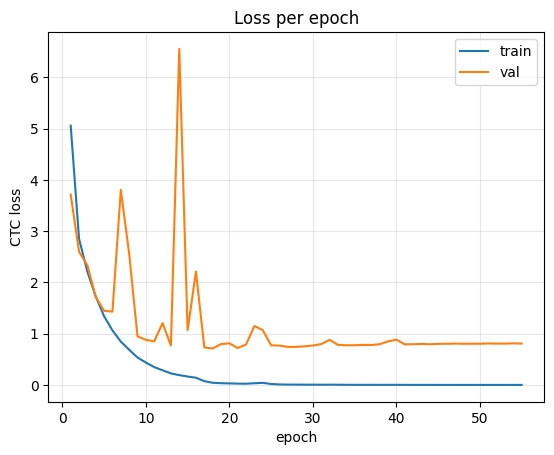

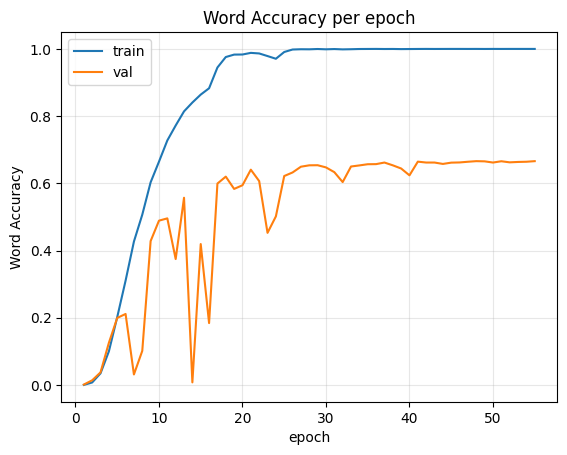

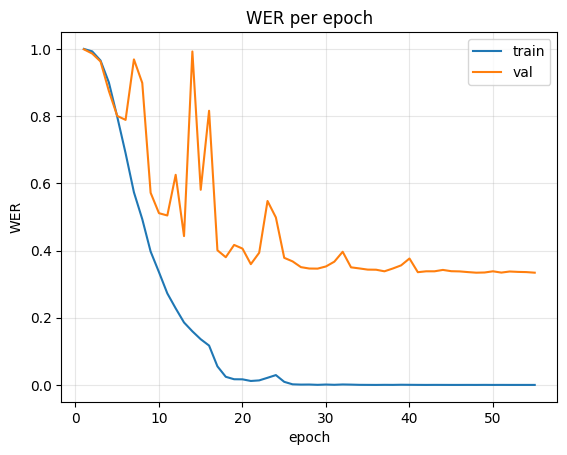

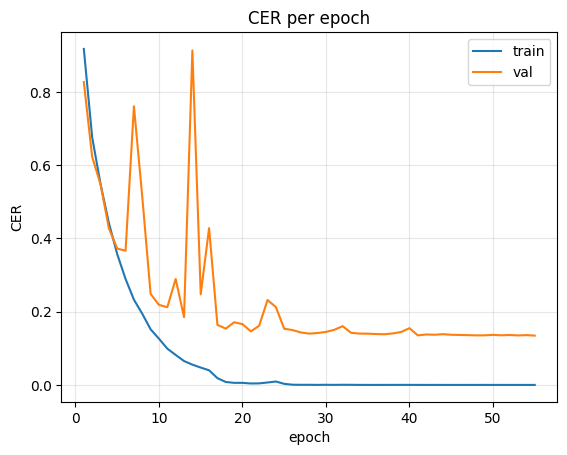

Saved PDFs in plots/: loss_train_val.pdf, word_acc_train_val.pdf, wer_train_val.pdf, cer_train_val.pdf


In [35]:
import os
import matplotlib.pyplot as plt

def plot_and_save(y1, y2, title, ylab, out_pdf):
    os.makedirs(os.path.dirname(out_pdf), exist_ok=True)

    n = min(len(y1), len(y2))
    x = list(range(1, n + 1))

    fig, ax = plt.subplots()
    ax.plot(x, y1[:n], label="train")
    ax.plot(x, y2[:n], label="val")
    ax.set_xlabel("epoch")
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    fig.savefig(out_pdf, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)

plot_and_save(history["train_loss"], history["val_loss"],
              "Loss per epoch", "CTC loss", "plots/loss_train_val.pdf")

plot_and_save(history["train_word_acc"], history["val_word_acc"],
              "Word Accuracy per epoch", "Word Accuracy", "plots/word_acc_train_val.pdf")

plot_and_save(history["train_wer"], history["val_wer"],
              "WER per epoch", "WER", "plots/wer_train_val.pdf")

plot_and_save(history["train_cer"], history["val_cer"],
              "CER per epoch", "CER", "plots/cer_train_val.pdf")

print("Saved PDFs in plots/: loss_train_val.pdf, word_acc_train_val.pdf, wer_train_val.pdf, cer_train_val.pdf")


In [36]:
epochs_run = len(history["train_loss"])
print("epochs actually ran:", epochs_run)


epochs actually ran: 55


# 11) Đánh giá TEST (WordAcc, WER, CER)

In [37]:
# load best
ckpt = torch.load("checkpoints/best.ckpt", map_location=cfg.device)
model1.load_state_dict(ckpt["model_state"])
model1.eval()

test_loss, test_acc, test_wer, test_cer = run_epoch(model1, test_loader, criterion,
                                                    optimizer=None, scaler=None,
                                                    train=False, itos=itos)
print(f"[TEST] loss {test_loss:.4f} | word_acc {test_acc:.4f} | WER {test_wer:.4f} | CER {test_cer:.4f}")


[TEST] loss 0.7583 | word_acc 0.6917 | WER 0.3083 | CER 0.1259


# 12) Inference thử 1 ảnh

In [38]:
@torch.no_grad()
def infer_one(image_path: str):
    model1.eval()
    img = Image.open(image_path).convert("L")
    w, h = img.size
    new_h = cfg.img_h
    new_w = int(w * (new_h / h))
    new_w = min(new_w, cfg.max_w)
    img = img.resize((new_w, new_h), Image.BILINEAR)
    arr = np.array(img).astype(np.float32) / 255.0
    arr = 1.0 - arr
    x = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).to(cfg.device)  # (1,1,H,W)

    log_probs = model1(x)  # (T,1,C)
    pred = greedy_decode(log_probs, itos)[0]
    return pred

# ví dụ:
sample_rel = train_items[0]["image_path"].replace("\\", "/")
sample_abs = os.path.join(cfg.DATA_ROOT, sample_rel)
print("Image:", sample_abs)
print("Pred:", infer_one(sample_abs))


Image: /content/data/InkData_word_processed/20160122_0078_25463_tg_2_2_23.png
Pred: trốn


In [39]:
sample_abs = os.path.join(cfg.DATA_ROOT, "InkData_word_processed/20140603_0003_BCCTC_tg_0_0_0.png")
print("Image:", sample_abs)
print("Pred:", infer_one(sample_abs))


Image: /content/data/InkData_word_processed/20140603_0003_BCCTC_tg_0_0_0.png
Pred: Bản


# 13) Visualize các trường hợp mô hình dự đoán sai và lưu pdf

## 13.1) Hàm lấy danh sách dự đoán sai

In [44]:
import os
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def collect_mistakes_greedy(model, loader, itos, max_samples=60):
    """
    Return list of dict: {"img": (H,W) numpy, "gt": str, "pred": str, "path": str}
    img lưu dạng hiển thị trắng nền - chữ đen (đã đảo lại cho dễ nhìn).
    """
    model.eval()
    mistakes = []

    for imgs, tgt_concat, tgt_lens, gt_texts, paths, raw_widths in tqdm(loader, leave=False):
        imgs = imgs.to(cfg.device)
        log_probs = model(imgs)  # (T,B,C)

        preds = greedy_decode(log_probs.detach(), itos)  # list[str], len=B

        B = imgs.shape[0]
        for i in range(B):
            gt = norm_text(gt_texts[i])
            pr = norm_text(preds[i])

            if pr != gt:
                # imgs[i]: (1,H,W) with ink=1 background=0 (do bạn đã invert lúc preprocess)
                # để vẽ: đảo lại -> nền trắng, chữ đen
                disp = 1.0 - imgs[i].detach().cpu().squeeze(0).numpy()  # (H,W)
                mistakes.append({
                    "img": disp,
                    "gt": gt,
                    "pred": pr,
                    "path": paths[i]
                })
                if len(mistakes) >= max_samples:
                    return mistakes

    return mistakes


# 13.1 Vẽ 1 PDF

In [64]:
import os, numpy as np
import matplotlib.pyplot as plt

def save_mistakes_one_page(mistakes, pdf_path="plots/mistakes_one_page.pdf",
                           n_show=9, ncols=3, figsize=(11.7, 8.3), also_show=True):
    os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

    if len(mistakes) == 0:
        print("No mistakes found.")
        return

    n = min(n_show, len(mistakes))
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for ax in axes:
        ax.axis("off")

    for i in range(n):
        item = mistakes[i]
        axes[i].imshow(item["img"], cmap="gray")
        axes[i].set_title(f"GT: {item['gt']}\nPR: {item['pred']}", fontsize=10)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.25)

    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")

    if also_show:
        plt.show()
    plt.close(fig)

    print(f"Saved ONE page ({n} samples) to: {pdf_path}")


## 13.2 Vẽ và lưu PDF (nhiều trang)

In [60]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def save_mistakes_pdf(mistakes, pdf_path="plots/mistakes.pdf", per_page=12, ncols=3, figsize=(11.7, 8.3)):
    """
    per_page: số ảnh mỗi trang
    ncols: số cột
    figsize: kích thước trang (mặc định gần A4 ngang)
    """
    os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

    n = len(mistakes)
    if n == 0:
        print("No mistakes found. Nothing to save.")
        return

    nrows = int(np.ceil(per_page / ncols))

    with PdfPages(pdf_path) as pdf:
        idx = 0
        while idx < n:
            fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
            axes = np.array(axes).reshape(-1)

            for ax in axes:
                ax.axis("off")

            for k in range(per_page):
                if idx >= n:
                    break

                item = mistakes[idx]
                ax = axes[k]
                ax.imshow(item["img"], cmap="gray")
                ax.set_title(f"GT: {item['gt']}\nPR: {item['pred']}", fontsize=10)
                idx += 1

            fig.tight_layout()
            fig.subplots_adjust(wspace=0.05, hspace=0.05)
            plt.show(fig)
            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)

    print(f"Saved {n} mistakes to: {pdf_path}")


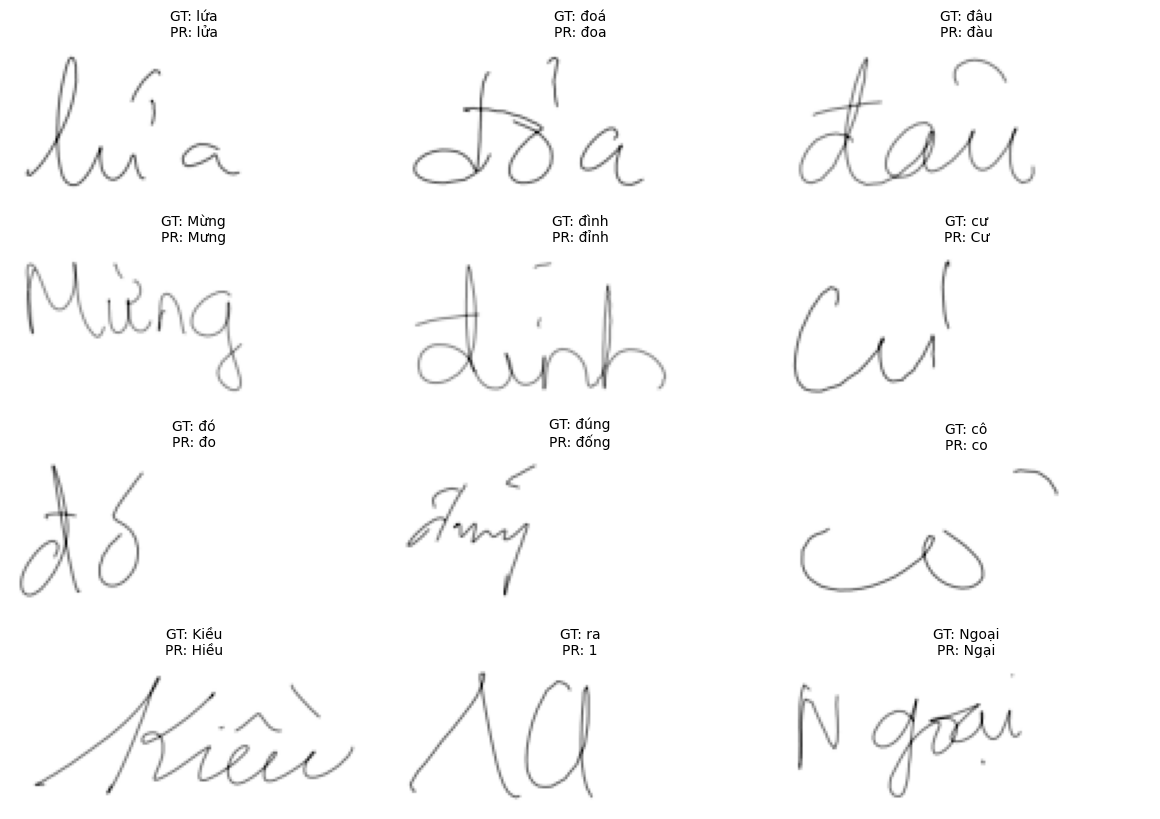

Saved ONE page (12 samples) to: plots/mistakes_val_one_page.pdf


In [61]:
mistakes_val = collect_mistakes_greedy(model1, val_loader, itos, max_samples=50)
save_mistakes_one_page(mistakes_val, "plots/mistakes_val_one_page.pdf", n_show=12, ncols=3)



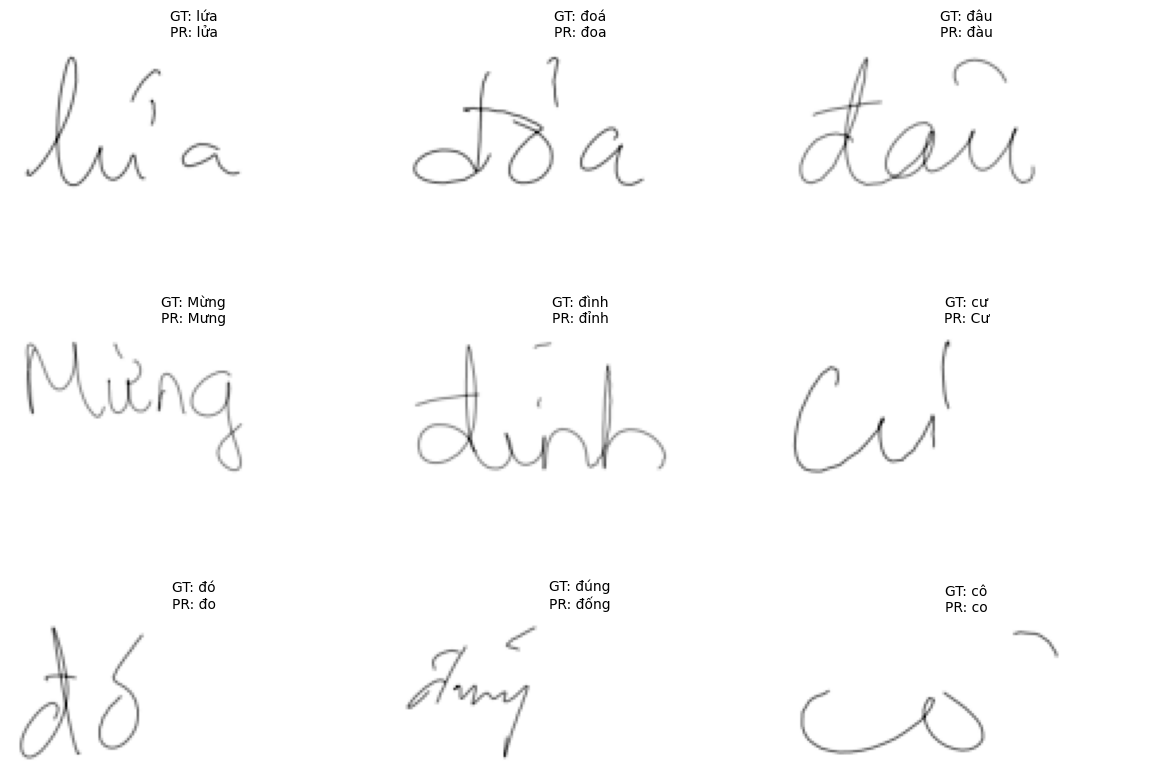

Saved ONE page (9 samples) to: plots/mistakes_val_one_page.pdf


In [63]:
mistakes_test = collect_mistakes_greedy(model1, test_loader, itos, max_samples=50)
save_mistakes_one_page(mistakes_val, "plots/mistakes_val_one_page.pdf", n_show=9, ncols=3)


# 14. Count Activation

In [65]:
import torch.nn as nn

ACT_TYPES = (
    nn.ReLU, nn.LeakyReLU, nn.PReLU, nn.ELU,
    nn.GELU, nn.SiLU, nn.Mish, nn.SELU, nn.Softplus,
    nn.Softmax, nn.LogSoftmax, nn.Sigmoid, nn.Tanh,
    nn.Hardswish, nn.Hardtanh
)

def list_activations(model: nn.Module):
    acts = []
    for name, m in model.named_modules():
        if isinstance(m, ACT_TYPES):
            acts.append((name, m.__class__.__name__, getattr(m, "inplace", None)))
    if len(acts) == 0:
        print("No explicit activation layers found.")
        return
    print("Activations used:")
    for name, cls, inplace in acts:
        if inplace is None:
            print(f" - {name}: {cls}")
        else:
            print(f" - {name}: {cls}(inplace={inplace})")


In [66]:
list_activations(model1)


Activations used:
 - cnn.2: SiLU(inplace=False)
 - cnn.6: SiLU(inplace=False)
 - cnn.10: SiLU(inplace=True)


# 16 Save report

In [70]:
import json
import numpy as np

summary = {
    "model": "CRNN + CTC",
    "total_paramenter": count_params(model1),
    "vocab_size": len(stoi),
    "activations": list_activations(model1),
    "layer_types": [m.__class__.__name__ for m in model1.modules()],
    "best_metric": float(cfg.best_metric),

    "metric": ["val_word_acc", "val_wer", "val_cer"],
    "metric_val": [history["val_word_acc"][-1], history["val_wer"][-1], history["val_cer"][-1]],
    "metric_train": [history["train_word_acc"][-1], history["train_wer"][-1], history["train_cer"][-1]],
    "metric_final": [test_acc, test_wer, test_cer],

    "best_epoch": cfg.best_epoch,
    "best_val_word_acc": float(cfg.best_metric),

    "final_train": {
        "loss": history["train_loss"][-1],
        "word_acc": history["train_word_acc"][-1],
        "wer": history["train_wer"][-1],
        "cer": history["train_cer"][-1],
    },

    "final_val": {
        "loss": history["val_loss"][-1],
        "word_acc": history["val_word_acc"][-1],
        "wer": history["val_wer"][-1],
        "cer": history["val_cer"][-1],
    },
    "final_test": {
        "loss": test_loss,
        "word_acc": test_acc,
        "wer": test_wer,
        "cer": test_cer,
    },
    "final_lr": history["lr"][-1],
    "final_epochs": epochs_run,


    "config": {
        "model": "CRNN + CTC",
        "vocab_size": len(stoi),
        "epochs_run": len(history["train_loss"]),
        "optimizer": "AdamW",
        "lr": cfg.lr,
        "batch_size": cfg.batch_size,
    }
}

with open("logs/summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)


Activations used:
 - cnn.2: SiLU(inplace=False)
 - cnn.6: SiLU(inplace=False)
 - cnn.10: SiLU(inplace=True)


# 15 Download

In [72]:
!zip -r CRNN_CTC.zip checkpoints plots logs

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/best_weights.pth (deflated 7%)
  adding: checkpoints/best.ckpt (deflated 7%)
  adding: checkpoints/last.ckpt (deflated 7%)
  adding: plots/ (stored 0%)
  adding: plots/wer_train_val.pdf (deflated 30%)
  adding: plots/mistakes_val_one_page.pdf (deflated 16%)
  adding: plots/cer_train_val.pdf (deflated 30%)
  adding: plots/mistakes_val.pdf (deflated 30%)
  adding: plots/word_acc_train_val.pdf (deflated 30%)
  adding: plots/mistakes_test.pdf (deflated 33%)
  adding: plots/loss_train_val.pdf (deflated 30%)
  adding: logs/ (stored 0%)
  adding: logs/train_log.csv (deflated 60%)
  adding: logs/summary.json (deflated 64%)
